<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Deutsch–Jozsa circuit for f(x)=x XOR 1:


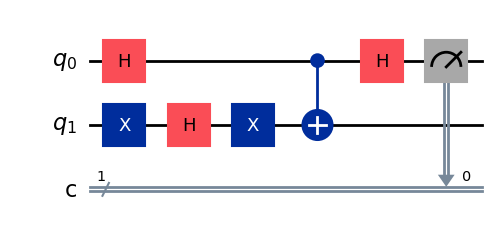

Measurement counts: {'1': 1024}
Algorithm result: BALANCED (expected for f(x)=x XOR 1)

2-qubit Deutsch–Jozsa for 'const-0':


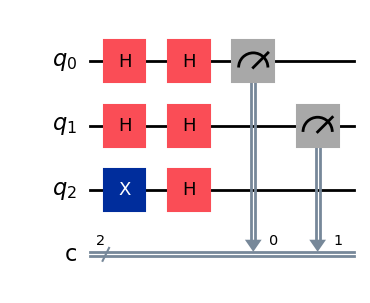

Counts: {'00': 1024}
Algorithm result: CONSTANT

2-qubit Deutsch–Jozsa for 'const-1':


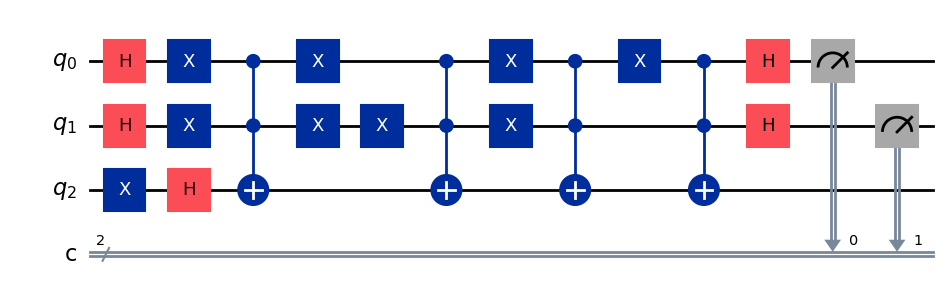

Counts: {'00': 1024}
Algorithm result: CONSTANT

2-qubit Deutsch–Jozsa for 'parity':


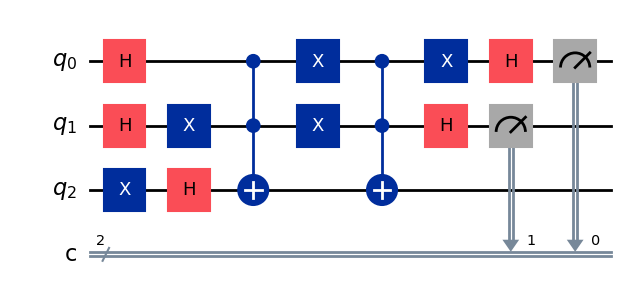

Counts: {'11': 1024}
Algorithm result: BALANCED

2-qubit parity counts under noise: {'11': 1796, '01': 116, '00': 53, '10': 83}
2-qubit parity counts ideal (no noise): {'11': 2048}

Classical vs Quantum Query Requirements:


,n,Classical worst-case queries,Quantum DJ queries
0,1,2,1
1,2,3,1
2,3,5,1
3,4,9,1



Example balanced function -> classical needs 2 queries; quantum needs 1.

All experiments complete ✅


In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# ------------------------------------------------------------
# Helper: Build Deutsch–Jozsa Circuit
# ------------------------------------------------------------
def dj_circuit(n, oracle_func):
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)
    qc.h(n)
    for i in range(n):
        qc.h(i)
    oracle_func(qc)
    for i in range(n):
        qc.h(i)
    for i in range(n):
        qc.measure(i, i)
    return qc


# ------------------------------------------------------------
# 1-Qubit Oracle: f(x) = x XOR 1
# ------------------------------------------------------------
def oracle_x_xor_1_single(qc):
    qc.x(1)
    qc.cx(0, 1)


# ------------------------------------------------------------
# Visualize Bloch Sphere Evolution
# ------------------------------------------------------------
n = 1
pre = QuantumCircuit(n + 1)
pre.x(n)
pre.h(n)
pre.h(0)

state_pre = Statevector.from_instruction(pre)
plot_bloch_multivector(state_pre)
plt.suptitle("Bloch spheres after Hadamards (before oracle)")
plt.show()

qc_oracle_only = QuantumCircuit(n + 1)
qc_oracle_only.append(pre.to_instruction(), range(n + 1))
oracle_x_xor_1_single(qc_oracle_only)
state_after_oracle = Statevector.from_instruction(qc_oracle_only)
plot_bloch_multivector(state_after_oracle)
plt.suptitle("Bloch spheres after oracle (f(x)=x XOR 1)")
plt.show()


# ------------------------------------------------------------
# Full 1-Qubit Deutsch–Jozsa Execution
# ------------------------------------------------------------
dj_qc = dj_circuit(1, oracle_x_xor_1_single)
print("Deutsch–Jozsa circuit for f(x)=x XOR 1:")
display(dj_qc.draw(output="mpl"))

qasm = Aer.get_backend("aer_simulator")
tqc = transpile(dj_qc, qasm)
job = qasm.run(tqc, shots=1024)
counts = job.result().get_counts()
print("Measurement counts:", counts)
if "0" in counts and counts["0"] == 1024:
    print("Algorithm result: CONSTANT")
else:
    print("Algorithm result: BALANCED (expected for f(x)=x XOR 1)")


# ------------------------------------------------------------
# 2-Qubit Extension Using Truth Tables
# ------------------------------------------------------------
def oracle_from_truth_table(truth_table):
    def oracle(qc):
        n = qc.num_qubits - 1
        for x, fx in truth_table.items():
            if fx == 1:
                bits = [(x >> i) & 1 for i in range(n)]
                for i, b in enumerate(bits):
                    if b == 0:
                        qc.x(i)
                qc.mcx(list(range(n)), n)
                for i, b in enumerate(bits):
                    if b == 0:
                        qc.x(i)
    return oracle


tt_const0 = {0: 0, 1: 0, 2: 0, 3: 0}
tt_const1 = {0: 1, 1: 1, 2: 1, 3: 1}
tt_parity = {0: 0, 1: 1, 2: 1, 3: 0}

for name, tt in [("const-0", tt_const0), ("const-1", tt_const1), ("parity", tt_parity)]:
    oracle_fn = oracle_from_truth_table(tt)
    qc2 = dj_circuit(2, oracle_fn)
    print(f"\n2-qubit Deutsch–Jozsa for '{name}':")
    display(qc2.draw(output="mpl"))
    t_qc2 = transpile(qc2, qasm)
    res = qasm.run(t_qc2, shots=1024).result()
    counts2 = res.get_counts()
    print("Counts:", counts2)
    if "00" in counts2 and counts2["00"] == 1024:
        print("Algorithm result: CONSTANT")
    else:
        print("Algorithm result: BALANCED")


# ------------------------------------------------------------
# Noise Impact
# ------------------------------------------------------------
noise_model = NoiseModel()
p1 = 0.005
single_err = depolarizing_error(p1, 1)
two_err = depolarizing_error(0.02, 2)
three_err = depolarizing_error(0.03, 3)

noise_model.add_all_qubit_quantum_error(single_err, ["h", "x", "u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(two_err, ["cx"])
noise_model.add_all_qubit_quantum_error(three_err, ["ccx", "mcx"])

ro_error = ReadoutError([[1 - 0.02, 0.02], [0.03, 1 - 0.03]])
for q in range(4):
    noise_model.add_readout_error(ro_error, [q])

sim_noisy = AerSimulator(method="density_matrix", noise_model=noise_model)
qc_parity = dj_circuit(2, oracle_from_truth_table(tt_parity))
t_noisy = transpile(qc_parity, sim_noisy)
res_noisy = sim_noisy.run(t_noisy, shots=2048).result()
counts_noisy = res_noisy.get_counts()
print("\n2-qubit parity counts under noise:", counts_noisy)

sim_ideal = AerSimulator(method="density_matrix")
t_ideal = transpile(qc_parity, sim_ideal)
res_ideal = sim_ideal.run(t_ideal, shots=2048).result()
counts_ideal = res_ideal.get_counts()
print("2-qubit parity counts ideal (no noise):", counts_ideal)

# ------------------------------------------------------------
# Classical vs Quantum Query Comparison
# ------------------------------------------------------------
print("\nClassical vs Quantum Query Requirements:")
rows = []
for n in [1, 2, 3, 4]:
    rows.append({"n": n,
                 "Classical worst-case queries": 2 ** (n - 1) + 1,
                 "Quantum DJ queries": 1})
df = pd.DataFrame(rows)
display(df)

example_tt = {0: 0, 1: 1, 2: 0, 3: 1}
def classical_naive_queries(truth_table):
    seen = set()
    for i, v in enumerate(truth_table.values(), start=1):
        seen.add(v)
        if len(seen) == 2:
            return i
    return len(truth_table)

needed = classical_naive_queries(example_tt)
print(f"\nExample balanced function -> classical needs {needed} queries; quantum needs 1.")
print("\nAll experiments complete ✅")
